## Treinando os modelos Category Boost Regressor (RFR) e ElasticNet (ELN):

### Bibliotecas utilizadas:

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

### Importando o dataset:

In [11]:
all_players_data = pd.read_csv("all_players_data.csv")

In [12]:
all_players_data.head()

,player_id,name,last_season,current_club_id,player_code,country_of_citizenship,date_of_birth,sub_position,position,foot,...,assists_2024,avg_minutes_2024,proporcao_titular,vezes_capitao_2024,player_preferred_formation,market_value_2019,market_value_2020,market_value_2021,market_value_2022,market_value_2023
0,3333,James Milner,2024,1237,james-milner,England,1986-01-04,Central Midfield,Midfield,right,...,0.0,59.000000,0.666667,0.0,4-2-3-1,12000000.0,5000000.0,2000000.0,2000000.0,1000000.0
1,5336,Anastasios Tsokanis,2024,60949,anastasios-tsokanis,Greece,1991-05-02,Defensive Midfield,Midfield,left,...,0.0,58.058824,0.428571,3.0,4-2-3-1,400000.0,350000.0,350000.0,450000.0,450000.0
2,7161,Jonas Hofmann,2024,15,jonas-hofmann,Germany,1992-07-14,Attacking Midfield,Midfield,right,...,5.0,54.967742,0.545455,0.0,4-2-3-1,9000000.0,14000000.0,16000000.0,13000000.0,13000000.0
3,7825,Pepe Reina,2024,1047,pepe-reina,Spain,1982-08-31,Goalkeeper,Goalkeeper,right,...,0.0,92.000000,0.285714,0.0,4-3-3 Attacking,800000.0,800000.0,800000.0,700000.0,700000.0
4,11530,Lionel Carole,2024,3205,lionel-carole,France,1991-04-12,Left-Back,Defender,left,...,1.0,80.000000,0.900000,0.0,4-2-3-1,2500000.0,2000000.0,2000000.0,1700000.0,850000.0


### Treinamento:

Utilizou-se a partição train_test_split(), com test_size = 0.3 e random_state = 42

In [13]:
def print_cv_results(name, results):
    print(f"\nResultados - {name}")
    print(f"R² (média): {np.mean(results['test_r2']):.4f}")
    print(f"RMSE (média): {-np.mean(results['test_neg_root_mean_squared_error']):.2f}")
    print(f"MAE (média): {-np.mean(results['test_neg_mean_absolute_error']):.2f}")

In [14]:
target = 'market_value_in_eur'

columns_to_exclude = [
    'player_id', 'name', 'player_code', 'date_of_birth', 'current_club_name',
    'market_value_in_eur'
]

X = all_players_data.drop(columns = columns_to_exclude)
y = all_players_data[target]

categorical_cols = X.select_dtypes(include = ['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include = ['int64', 'float64']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Preprocessor:

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder = 'passthrough'
)

CatBoost Regressor:

In [16]:
cb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(random_state = 42))
])

In [17]:
cb_param_grid = {
    'model__iterations': [500, 1000],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__depth': [4, 6, 8],
    'model__l2_leaf_reg': [1, 3, 5],
    'model__border_count': [32, 64],
}

In [18]:
cb_grid = GridSearchCV(cb_pipeline, cb_param_grid, cv = 5, scoring = 'r2', n_jobs = -1)
cb_grid.fit(X, y)
print("Melhores parâmetros RF:", cb_grid.best_params_)

0:	learn: 12144875.8654178	total: 148ms	remaining: 2m 27s
1:	learn: 11395955.7607419	total: 151ms	remaining: 1m 15s
2:	learn: 10701487.0871452	total: 155ms	remaining: 51.4s
3:	learn: 10069980.3516371	total: 158ms	remaining: 39.4s
4:	learn: 9434200.5994178	total: 162ms	remaining: 32.2s
5:	learn: 8838570.0250706	total: 165ms	remaining: 27.3s
6:	learn: 8318853.5085778	total: 168ms	remaining: 23.9s
7:	learn: 7877286.8391040	total: 172ms	remaining: 21.3s
8:	learn: 7499099.6915548	total: 175ms	remaining: 19.3s
9:	learn: 7155481.9852792	total: 179ms	remaining: 17.7s
10:	learn: 6812400.7092267	total: 182ms	remaining: 16.3s
11:	learn: 6480816.4960396	total: 185ms	remaining: 15.2s
12:	learn: 6177590.4023484	total: 188ms	remaining: 14.3s
13:	learn: 5899751.1951802	total: 191ms	remaining: 13.5s
14:	learn: 5689859.3149826	total: 195ms	remaining: 12.8s
15:	learn: 5460341.9853018	total: 199ms	remaining: 12.2s
16:	learn: 5243923.8859464	total: 202ms	remaining: 11.7s
17:	learn: 5091973.8947502	total: 2

Elastic Net:

In [19]:
eln_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ElasticNet(random_state = 42))
])

In [20]:
eln_param_grid = {
    'model__alpha': [0.01, 0.1, 1.0, 10.0],   
    'model__l1_ratio': [0.1, 0.5, 0.9, 1.0],
}

In [21]:
eln_grid = GridSearchCV(eln_pipeline, eln_param_grid, cv = 5, scoring = 'r2', n_jobs = -1)
eln_grid.fit(X, y)
print("Melhores parâmetros XGBoost:", eln_grid.best_params_)

Melhores parâmetros XGBoost: {'model__alpha': 1.0, 'model__l1_ratio': 0.9}


In [22]:
scoring = {
    'r2': 'r2',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error'
}

In [23]:
cb_results = cross_validate(cb_grid.best_estimator_, X, y, cv = 5, scoring = scoring, return_train_score = True)
eln_results = cross_validate(eln_grid.best_estimator_, X, y, cv = 5, scoring = scoring, return_train_score = True)

0:	learn: 13104095.3782602	total: 3.69ms	remaining: 3.68s
1:	learn: 12327633.0333142	total: 7.1ms	remaining: 3.54s
2:	learn: 11494986.1709710	total: 11.4ms	remaining: 3.79s
3:	learn: 10812259.5069865	total: 15.2ms	remaining: 3.77s
4:	learn: 10107071.9116468	total: 18.6ms	remaining: 3.7s
5:	learn: 9578305.9512615	total: 22.1ms	remaining: 3.66s
6:	learn: 9129253.5031724	total: 25.9ms	remaining: 3.67s
7:	learn: 8632612.7538335	total: 29.7ms	remaining: 3.68s
8:	learn: 8141964.6263924	total: 33.4ms	remaining: 3.68s
9:	learn: 7755038.8005457	total: 36.9ms	remaining: 3.65s
10:	learn: 7347577.8828784	total: 40.5ms	remaining: 3.64s
11:	learn: 6971490.2643346	total: 44.2ms	remaining: 3.64s
12:	learn: 6649680.7802622	total: 47.8ms	remaining: 3.63s
13:	learn: 6344165.7338022	total: 51.3ms	remaining: 3.61s
14:	learn: 6055755.0871153	total: 55ms	remaining: 3.61s
15:	learn: 5834879.8190747	total: 58.5ms	remaining: 3.6s
16:	learn: 5615538.7749790	total: 62.1ms	remaining: 3.59s
17:	learn: 5419748.11571

In [24]:
print_cv_results("CatBoost", cb_results)
print_cv_results("ElasticNet", eln_results)


Resultados - CatBoost
R² (média): 0.8663
RMSE (média): 4076626.15
MAE (média): 1412712.75

Resultados - ElasticNet
R² (média): 0.7238
RMSE (média): 4901351.53
MAE (média): 2539869.68


In [25]:
results_df = pd.DataFrame({
    'Modelo': ['Random Forest'] * 5 + ['XGBoost'] * 5,
    'R²': np.concatenate([cb_results['test_r2'], eln_results['test_r2']]),
    'RMSE': -np.concatenate([cb_results['test_neg_root_mean_squared_error'], eln_results['test_neg_root_mean_squared_error']]),
    'MAE': -np.concatenate([cb_results['test_neg_mean_absolute_error'], eln_results['test_neg_mean_absolute_error']])
})

In [26]:
results_long = results_df.melt(id_vars = 'Modelo', var_name = 'Métrica', value_name = 'Valor')

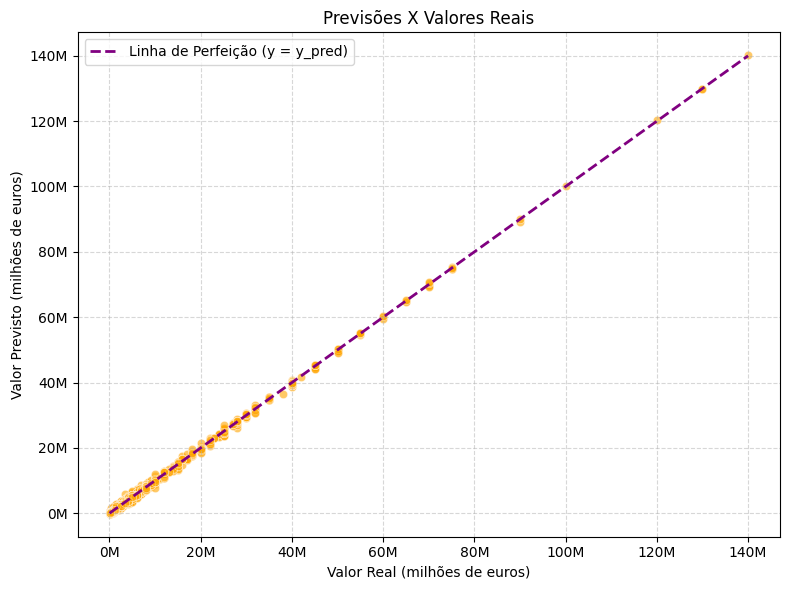

In [27]:
# Previsões com o modelo CatBoost já treinado
y_pred = cb_grid.predict(X_test)

# Converter valores para milhões
y_test_mil = y_test / 1e6
y_pred_mil = y_pred / 1e6

# Função para formatar os valores dos eixos como milhões
def milhões(x, pos):
    return f'{x:.0f}M'

formatter = FuncFormatter(milhões)

# Gráfico de dispersão
plt.figure(figsize = (8, 6))
sns.scatterplot(x = y_test_mil, y = y_pred_mil, alpha = 0.6, color = 'orange')

plt.plot([y_test_mil.min(), y_test_mil.max()],
         [y_test_mil.min(), y_test_mil.max()],
         color = 'purple', lw = 2, linestyle = '--', label = 'Linha de Perfeição (y = y_pred)')

plt.title('Previsões X Valores Reais')
plt.xlabel('Valor Real (milhões de euros)')
plt.ylabel('Valor Previsto (milhões de euros)')
plt.legend()
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

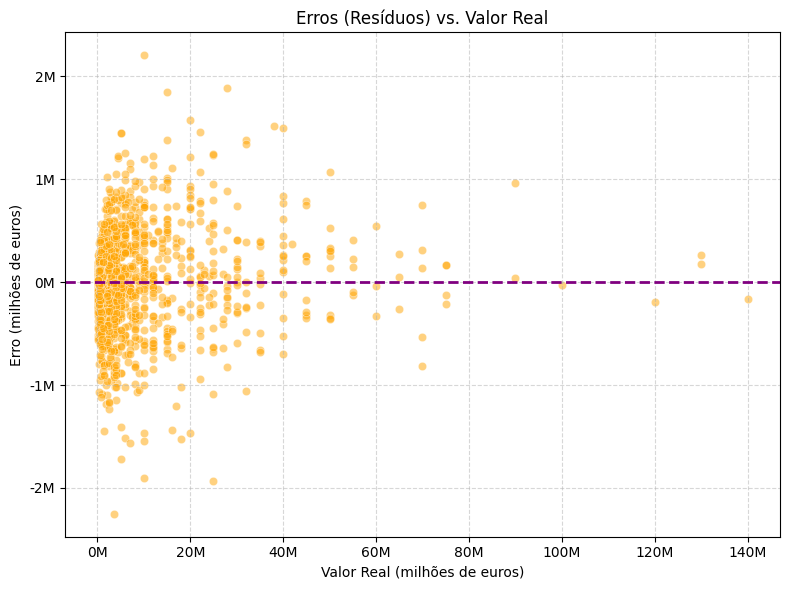

In [28]:
# Cálculo dos resíduos
residuals = y_test - y_pred

# Converter para milhões de euros
y_test_mil = y_test / 1e6
residuals_mil = residuals / 1e6

# Formatador de milhões
def milhões(x, pos):
    return f'{x:.0f}M'

formatter = FuncFormatter(milhões)

# Gráfico de resíduos
plt.figure(figsize = (8, 6))
sns.scatterplot(x = y_test_mil, y = residuals_mil, alpha = 0.5, color = 'orange')

plt.axhline(0, color = 'purple', linestyle = '--', lw = 2)
plt.title('Erros (Resíduos) vs. Valor Real')
plt.xlabel('Valor Real (milhões de euros)')
plt.ylabel('Erro (milhões de euros)')
plt.grid(True, linestyle = '--', alpha = 0.5)

# Aplicar formatador nos eixos
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

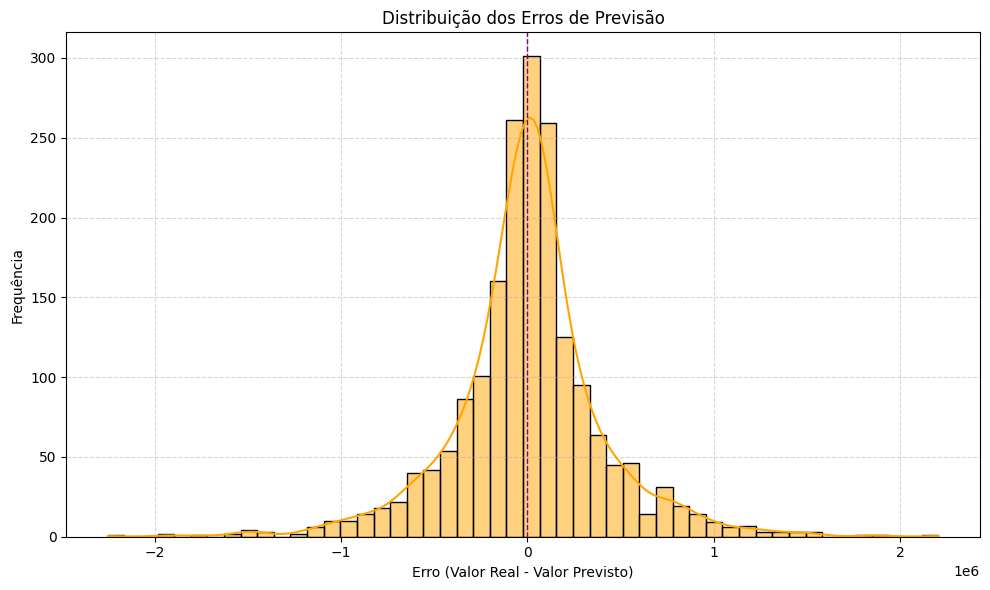

In [29]:
plt.figure(figsize = (10, 6))
sns.histplot(residuals, bins = 50, kde = True, color = 'orange')

plt.axvline(0, color = 'purple', linestyle = '--', lw = 1)
plt.title('Distribuição dos Erros de Previsão')
plt.xlabel('Erro (Valor Real - Valor Previsto)')
plt.ylabel('Frequência')
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.tight_layout()
plt.show()